In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm

import statsmodels.formula.api as smf
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

In [2]:
d = pd.read_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_2013_2018.csv')


In [3]:
#### Data Preparation for CDAM model

trips_per_day = d.groupby(['year','month','day'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trips_per_day['trips'] = trips_per_day['interactions']/2
trips_per_day['transformed_trips'] = (trips_per_day['interactions'] + abs(trips_per_day['bike_arr_dep']) - trips_per_day['rebalance'])/2
trips_per_day['transformed_trips']  = trips_per_day['transformed_trips'].apply(np.ceil)
active_stations = d.groupby(['year','month','day'])['interactions'].count().reset_index(name ='activity_count')

For the interval aggregation model (IAM) we modify Eq. (20) to use the D temporal resolution data to estimate the number
of interactions rather than daily trips. IAM sums interactions across all station in the BSS for each interval duration. The
BSS normalization variable AzDdt from Eq. (15) is included as well as it’s square to compensate for interaction collision losses.

In [4]:
df_cdam = pd.merge(trips_per_day, active_stations, on = ['year','month','day'], how = 'inner')
df_cdam['trips']  = df_cdam['trips'].apply(np.ceil)
df_cdam['trips_sq'] =  df_cdam['trips'] * df_cdam['trips']
df_cdam['trips_sq_activity_normalised'] = df_cdam['trips_sq'] / df_cdam['activity_count']
df_cdam = df_cdam[['transformed_trips','trips','trips_sq_activity_normalised']]
df_cdam.sample(5)

,transformed_trips,trips,trips_sq_activity_normalised
116,2002.0,2147.0,1695.332475
57,3233.0,3415.0,3199.513032
993,3756.0,3873.0,3039.539818
759,5499.0,6115.0,6464.942082
1466,3113.0,3291.0,2475.584229


### CDAM Basic Model

## Assumptions for Linear Regression

### Linearity

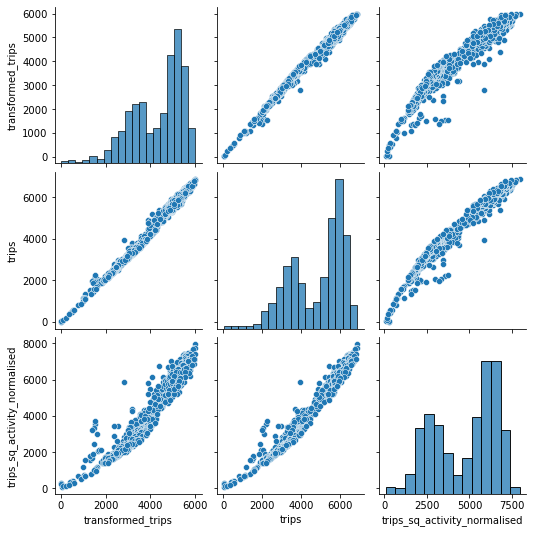

In [5]:
### Pairs Plot
p = sns.pairplot(df_cdam)

From the above plot we can see that there is linear relationship between tranformed_trip and the trips. So the Linearity assumption is satisfied.

### Training and Testing cDAM Model

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(df_cdam,df_cdam, test_size = 0.3,random_state=0)
cdam_model = smf.ols(formula='transformed_trips ~ 0 + trips + trips_sq_activity_normalised', data=xtrain).fit()
y_pred = cdam_model.predict(xtest)
print(cdam_model.summary())

                                 OLS Regression Results                                
Dep. Variable:      transformed_trips   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.791e+06
Date:                Tue, 26 Jul 2022   Prob (F-statistic):                        0.00
Time:                        10:36:40   Log-Likelihood:                         -6176.7
No. Observations:                1072   AIC:                                  1.236e+04
Df Residuals:                    1070   BIC:                                  1.237e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

### Mean of Residuals
Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.

In [7]:
residuals = xtest['transformed_trips']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_trips'], y_pred))/(xtest['transformed_trips'].mean())))

Mean of Residuals -2.9329152514901278
NRMSE 0.01753417378973817


In [8]:
residuals.describe()

count    460.000000
mean      -2.932915
std       74.852135
min     -289.446110
25%      -51.217028
50%       -0.952851
75%       45.892516
max      208.926615
dtype: float64

### Detecting heteroscedasticity!

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

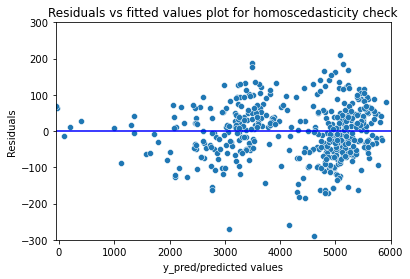

In [9]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-300,300)
plt.xlim(-60,6000)
p = sns.lineplot([-60,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic.

Alternative Hypothesis: Error terms are heteroscedastic.

In [10]:
X_train =  xtest.drop(["transformed_trips"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0345248022192928), ('p-value', 0.39898662622064196)]

Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic. Good

### Check for Normality of error terms/residuals

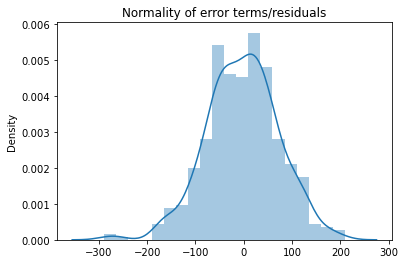

In [11]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms are pretty much normally distributed for the number of test points we took. Remember the central limit theorem which says that as the sample size increases the distribution tends to be normal. A skew is also visible from the plot. It's very difficult to get perfect curves, distributions in real life data.

### Autocorrelation of residuals

When the residuals are autocorrelated, it means that the current value is dependent of the previous (historic) values and that there is a definite unexplained pattern in the Y variable that shows up in the error terms. Though it is more evident in time series data.

Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.

Null Hypothesis: Autocorrelation is absent.

Alternative Hypothesis: Autocorrelation is present.

In [12]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.04168691149849478

Since p value is less than 0.05 we reject null hypothesis. Hence Auto Correlation is present.

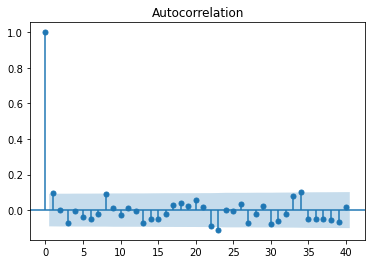

In [13]:
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

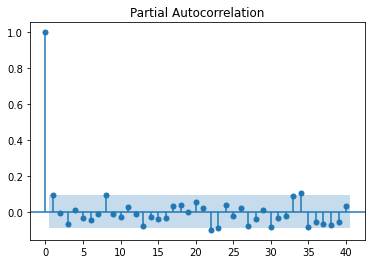

In [14]:
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

There results doesn't show any auto correlation, as we couldnt see any spikes outsided the blue confidence interval region.

Reference : https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression/notebook